In [1]:
import os
import numpy as np
import sys
import nibabel as nib
import matplotlib.pyplot as plt

In [2]:
def show_slices(slices,clims=[0.0,0.0]):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1,len(slices))
    for i, slice in enumerate(slices):
        if clims==[0.0,0.0]:
            axes[i].imshow(slice.T, cmap='gray', origin="lower")
        else:
            axes[i].imshow(slice.T, cmap='gray', origin="lower", clim=clims)
            
def maxk(A,k):
    B=np.sort(np.ndarray.flatten(A))
    t=size(B)
    y=B[t-k+1:]
    return y

def size(A):
    sizei = 1
    for dim in np.shape(A): sizei *= dim
    return sizei


In [3]:
print('Number of arguments:', len(sys.argv), 'arguments.')
a=sys.argv[1:]
print('Argument List:', a)

if not a:
    print('Please provide arguments for the python script:')
    print('    first argument: directory where the data is stored')
    print('    second argument: subject ID of the patient (prefix of the image name, including the scan number)')
    print('                     (for example Subject_01_PSIR_6_1 )')
    print('    third argument: suffix of the image (either .img, .nii or .nii.gz)')
    print('    fourth argument: reconstruction software (either ptoa or dcm2niix)')
    print('')
    print('N.B.: Please check that there is no full stop (.) inside the file name.')
    sys.exit()
elif a[0]=='-f' or a[0]=='--ip=127.0.0.1':
    print('You are on the notebook, please check below the ID, directory and suffix of images provided.')
    #in_dir='C:\\Users\\ppzom1\\Downloads\\OneDrive_1_17-06-2021'
    in_dir='/home/olivier/Documents/work_todo/Bitan/test'
    sub_ID='T1TFE_20201117132607_WIPPSIR_0.55mmSENSE_4'
    sub_dir=in_dir+'/'+sub_ID
    suffix='.nii.gz'
    recon='dcm2niix'
    resol='0p55mm'
    show_data=True
else:
    in_dir=a[0]
    sub_ID=a[1]
    suffix=a[2]
    recon=a[3]
    resol=a[4]
    sub_dir=in_dir+'/'+sub_ID
    show_data=True


print(os.getcwd())
out_dir = os.path.join(in_dir)

### Need to remove the . in filenames otherwise conflicts!!! such as this
#EPI_AK_06_WIP_PSIR_UK7T_0.7mm_BestNPI_SENSE_5_1_modulus_cphase00

#sub_ID='MEPFM_Sub15_WIP_MP2RAGE_8_1'
#sub_dir=in_dir+'/'+sub_ID
#suffix='.img'

Number of arguments: 3 arguments.
Argument List: ['-f', '/home/olivier/.local/share/jupyter/runtime/kernel-c253b40d-a6e4-4aec-8031-7619ae15a6b4.json']
You are on the notebook, please check below the ID, directory and suffix of images provided.
/home/olivier/Documents/softwares/PSIR/PSIR_conversion


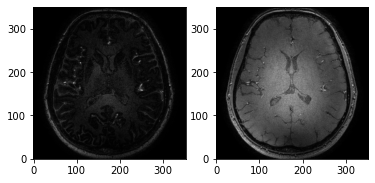

In [4]:
if recon == 'ptoa':
    imgm1=nib.load(sub_dir+'_modulus_cphase00'+suffix)
    imgm2=nib.load(sub_dir+'_modulus_cphase01'+suffix)
    imgp1=nib.load(sub_dir+'_phase_cphase00'+suffix)
    imgp2=nib.load(sub_dir+'_phase_cphase01'+suffix)
elif recon == 'dcm2niix':
    if resol == '0p7mm':
        imgm1=nib.load(sub_dir+'_t732'+suffix)
        imgm2=nib.load(sub_dir+'_t2157'+suffix)
        imgp1=nib.load(sub_dir+'_ph_t732'+suffix)
        imgp2=nib.load(sub_dir+'_ph_t2157'+suffix) 
    elif resol == '0p55mm':
        imgm1=nib.load(sub_dir+'_t807'+suffix)
        imgm2=nib.load(sub_dir+'_t2607'+suffix)
        imgp1=nib.load(sub_dir+'_ph_t807'+suffix)
        imgp2=nib.load(sub_dir+'_ph_t2607'+suffix)

    
hdr = imgm1.header
imgm1_data=np.squeeze(imgm1.get_fdata())
imgm2_data=np.squeeze(imgm2.get_fdata())
imgp1_data=np.squeeze(imgp1.get_fdata())
imgp2_data=np.squeeze(imgp2.get_fdata())

if show_data:
    midslice=int(imgm1_data.shape[2]/2)
    midy=int(imgm1_data.shape[1]/2)
    midx=int(imgm1_data.shape[0]/2)
    show_slices([np.abs(imgm1_data[:,:,midslice]),
                 np.abs(imgm2_data[:,:,midslice])])

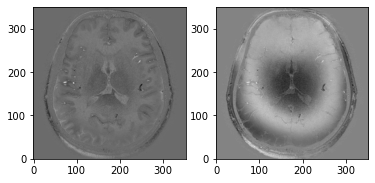

In [5]:
# Phase in radian and four volumes to deal with:

S1 = np.multiply(imgm1_data,np.exp(1j*imgp1_data))
S2 = np.multiply(imgm2_data,np.exp(1j*imgp2_data))


if show_data:
    show_slices([np.real(S1[:,:,midslice]),
                 np.real(S2[:,:,midslice])])


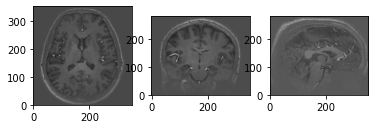

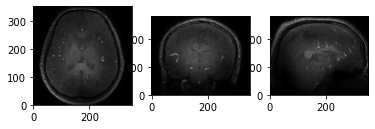

In [6]:
T1w=np.real(np.multiply(np.conj(S1),S2));
f=np.sign(T1w)
S1m=np.multiply(np.abs(S1),f)
S0=(np.abs(S1m)+np.abs(S2))


if show_data:
    show_slices([S1m[:,:,midslice],S1m[:,midy,:],S1m[midx,:,:]])
    show_slices([S0[:,:,midslice],S0[:,midy,:],S0[midx,:,:]])   


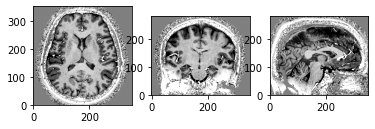

In [7]:
PSIR=np.divide(S1m,S0,out=np.zeros_like(S1m), where=(S0!=0))
  
mask=(S0>0)
PSIR=np.multiply(PSIR,mask)
mask=(PSIR<-2)
np.put(PSIR,mask,-2)
mask=(PSIR>2)
np.put(PSIR,mask,2)

PSIR_img = nib.nifti1.Nifti1Image(PSIR, None, header=imgm1.header)
PSIR_img.to_filename(sub_dir+'_PSIR.nii.gz')


if show_data:
    show_slices([PSIR[:,:,midslice],PSIR[:,midy,:],PSIR[midx,:,:]],[-0.5,0.5])
    

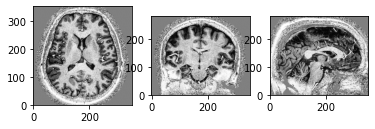

In [8]:
MP2RAGEn=np.real(np.multiply(np.conj(S1),S2))
MP2RAGEd=np.square(np.abs(S1))+np.square(np.abs(S2))
MP2RAGE=np.divide(MP2RAGEn,MP2RAGEd,out=np.zeros_like(MP2RAGEn), where=(MP2RAGEd!=0))

MP2RAGE_img = nib.nifti1.Nifti1Image(MP2RAGE, None, header=imgm1.header)
MP2RAGE_img.to_filename(sub_dir+'_MP2RAGE.nii.gz')

if show_data:
    show_slices([(MP2RAGE[:,:,midslice]),(MP2RAGE[:,midy,:]),(MP2RAGE[midx,:,:])],[-0.5,0.5])


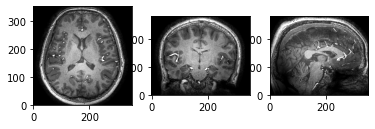

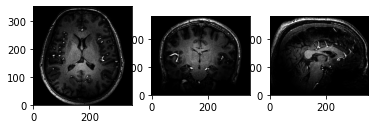

In [9]:

aa=1
beta=aa*np.min(maxk(np.abs(S2),round(size(S2)/100)))
beta2=aa*np.min(maxk(np.abs(MP2RAGEd),round(size(MP2RAGEd)/100)))
# print(str(beta)+' as well as '+str(beta2))

PSIRbeta=(np.divide(S1m-beta,S0+beta,out=np.zeros_like(S1m), where=(S0+beta!=0))+1)*200
MP2RAGEbeta=(np.divide(MP2RAGEn-beta2,MP2RAGEd+2*beta2,out=np.zeros_like(MP2RAGEn), where=(MP2RAGEd+2*beta2!=0))+0.5)*400

PSIRbeta_img = nib.nifti1.Nifti1Image(PSIRbeta, None, header=imgm1.header)
PSIRbeta_img.to_filename(sub_dir+'_PSIRbeta.nii.gz')
MP2RAGEbeta_img = nib.nifti1.Nifti1Image(MP2RAGEbeta, None, header=imgm1.header)
MP2RAGEbeta_img.to_filename(sub_dir+'_MP2RAGEbeta.nii.gz')


if show_data:
    show_slices([(PSIRbeta[:,:,midslice]),(PSIRbeta[:,midy,:]),(PSIRbeta[midx,:,:])],[0,200])
    show_slices([(MP2RAGEbeta[:,:,midslice]),(MP2RAGEbeta[:,midy,:]),(MP2RAGEbeta[midx,:,:])],[0,200]) 
    

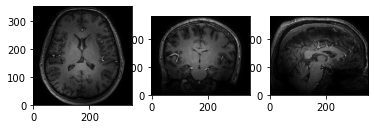

In [10]:
TI2_PSIR=np.multiply(PSIR+1,abs(S2))
if show_data:
    show_slices([(TI2_PSIR[:,:,midslice]),(TI2_PSIR[:,midy,:]),(TI2_PSIR[midx,:,:])])

TI2_PSIR_img = nib.nifti1.Nifti1Image(TI2_PSIR, None, header=imgm1.header)
TI2_PSIR_img.to_filename(sub_dir+'_TI2_PSIR.nii.gz')

